In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns

import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

In [ ]:
print(os.listdir(r'/content/drive/MyDrive/data'))

['data credit.txt', 'train', 'unknown(test)', 'test']


In [ ]:
folder_benign_train = r'/content/drive/MyDrive/data/train/benign'
folder_malignant_train = r'/content/drive/MyDrive/data/train/malignant'

folder_benign_test = r'/content/drive/MyDrive/data/test/benign'
folder_malignant_test = r'/content/drive/MyDrive/data/test/malignant'

In [ ]:
read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Load in training pictures 
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Load in testing pictures
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

# Create labels
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])


# Merge data 
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

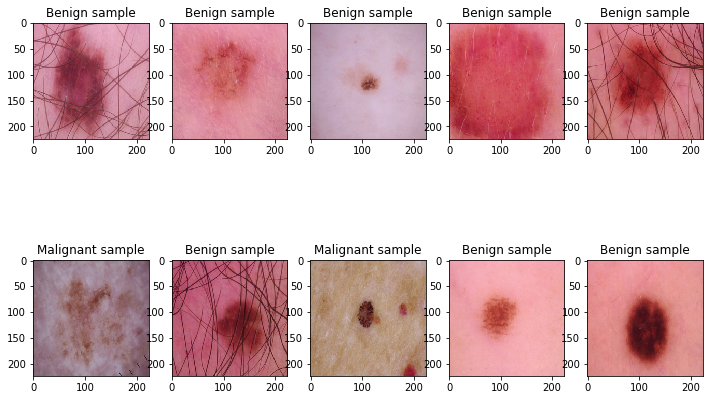

In [ ]:
# image dimensions for display
# Not Necessary
w = 30
h = 10
fig = plt.figure(figsize=(12,8))
columns = 5
rows = 2

for i in range(1, columns*rows + 1):
    ax = fig.add_subplot(rows, columns, i)
    if( y_train[i] == 0 ):
        ax.title.set_text('Benign sample')
    else:
        ax.title.set_text('Malignant sample')
    plt.imshow(X_train[i], interpolation = 'nearest')
plt.show()

In [ ]:
#again added few more extra packages

import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
np.random.seed(20)
from sklearn.metrics import accuracy_score

import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras import backend as K
from keras.optimizers import Adam  
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import ResNet50

In [ ]:
# Convert labels into one hot encoding
#extra coding part is implemented here...just for encoding purpose
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [ ]:
# data Normalization
X_train = X_train/255
X_test = X_test/255

In [ ]:
# ResNet-50 Model building
input_shape = (224,224,3)
lr = 1e-5 # learning rate
epochs = 50
batch_size = 32

# set learning rate reduction
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                           patience=5,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=1e-7)
model = ResNet50(include_top = True,
                weights = None,
                input_tensor = None, 
                input_shape=input_shape,
                pooling='avg',
                classes=2)

In [ ]:
# from tensorflow.python.keras.optimizer_v2.optimizer_v2 import OptimizerV2
# from tensorflow.python import ops, math_ops, state_ops, control_flow_ops
# from tensorflow.python.keras import backend as K

# __all__ = ['RAdam']


# class RAdam(OptimizerV2):
#     """RAdam optimizer.
#     According to the paper
#     [On The Variance Of The Adaptive Learning Rate And Beyond](https://arxiv.org/pdf/1908.03265v1.pdf).
#     """

#     def __init__(self,
#                  learning_rate=0.001,
#                  beta_1=0.9,
#                  beta_2=0.999,
#                  epsilon=1e-7,
#                  weight_decay=0.,
#                  amsgrad=False,
#                  total_steps=0,
#                  warmup_proportion=0.1,
#                  min_lr=0.,
#                  name='RAdam',
#                  **kwargs):
#         r"""Construct a new Adam optimizer.
#         Args:
#             learning_rate: A Tensor or a floating point value.    The learning rate.
#             beta_1: A float value or a constant float tensor. The exponential decay
#                 rate for the 1st moment estimates.
#             beta_2: A float value or a constant float tensor. The exponential decay
#                 rate for the 2nd moment estimates.
#             epsilon: A small constant for numerical stability. This epsilon is
#                 "epsilon hat" in the Kingma and Ba paper (in the formula just before
#                 Section 2.1), not the epsilon in Algorithm 1 of the paper.
#             weight_decay: A floating point value. Weight decay for each param.
#             amsgrad: boolean. Whether to apply AMSGrad variant of this algorithm from
#                 the paper "On the Convergence of Adam and beyond".
#             total_steps: An integer. Total number of training steps.
#                 Enable warmup by setting a positive value.
#             warmup_proportion: A floating point value. The proportion of increasing steps.
#             min_lr: A floating point value. Minimum learning rate after warmup.
#             name: Optional name for the operations created when applying gradients.
#                 Defaults to "Adam".    @compatibility(eager) When eager execution is
#                 enabled, `learning_rate`, `beta_1`, `beta_2`, and `epsilon` can each be
#                 a callable that takes no arguments and returns the actual value to use.
#                 This can be useful for changing these values across different
#                 invocations of optimizer functions. @end_compatibility
#             **kwargs: keyword arguments. Allowed to be {`clipnorm`, `clipvalue`, `lr`,
#                 `decay`}. `clipnorm` is clip gradients by norm; `clipvalue` is clip
#                 gradients by value, `decay` is included for backward compatibility to
#                 allow time inverse decay of learning rate. `lr` is included for backward
#                 compatibility, recommended to use `learning_rate` instead.
#         """

#         super(RAdam, self).__init__(name, **kwargs)
#         self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
#         self._set_hyper('beta_1', beta_1)
#         self._set_hyper('beta_2', beta_2)
#         self._set_hyper('decay', self._initial_decay)
#         self._set_hyper('weight_decay', weight_decay)
#         self._set_hyper('total_steps', float(total_steps))
#         self._set_hyper('warmup_proportion', warmup_proportion)
#         self._set_hyper('min_lr', min_lr)
#         self.epsilon = epsilon or K.epsilon()
#         self.amsgrad = amsgrad
#         self._initial_weight_decay = weight_decay
#         self._initial_total_steps = total_steps

#     def _create_slots(self, var_list):
#         for var in var_list:
#             self.add_slot(var, 'm')
#         for var in var_list:
#             self.add_slot(var, 'v')
#         if self.amsgrad:
#             for var in var_list:
#                 self.add_slot(var, 'vhat')

#     def set_weights(self, weights):
#         params = self.weights
#         num_vars = int((len(params) - 1) / 2)
#         if len(weights) == 3 * num_vars + 1:
#             weights = weights[:len(params)]
#         super(RAdam, self).set_weights(weights)

#     def _resource_apply_dense(self, grad, var):
#         var_dtype = var.dtype.base_dtype
#         lr_t = self._decayed_lr(var_dtype)
#         m = self.get_slot(var, 'm')
#         v = self.get_slot(var, 'v')
#         beta_1_t = self._get_hyper('beta_1', var_dtype)
#         beta_2_t = self._get_hyper('beta_2', var_dtype)
#         epsilon_t = ops.convert_to_tensor(self.epsilon, var_dtype)
#         local_step = math_ops.cast(self.iterations + 1, var_dtype)
#         beta_1_power = math_ops.pow(beta_1_t, local_step)
#         beta_2_power = math_ops.pow(beta_2_t, local_step)

#         if self._initial_total_steps > 0:
#             total_steps = self._get_hyper('total_steps', var_dtype)
#             warmup_steps = total_steps * self._get_hyper('warmup_proportion', var_dtype)
#             min_lr = self._get_hyper('min_lr', var_dtype)
#             decay_steps = K.maximum(total_steps - warmup_steps, 1)
#             decay_rate = (min_lr - lr_t) / decay_steps
#             lr_t = tf.where(
#                 local_step <= warmup_steps,
#                 lr_t * (local_step / warmup_steps),
#                 lr_t + decay_rate * K.minimum(local_step - warmup_steps, decay_steps),
#             )

#         sma_inf = 2.0 / (1.0 - beta_2_t) - 1.0
#         sma_t = sma_inf - 2.0 * local_step * beta_2_power / (1.0 - beta_2_power)

#         m_t = state_ops.assign(m,
#                                beta_1_t * m + (1.0 - beta_1_t) * grad,
#                                use_locking=self._use_locking)
#         m_corr_t = m_t / (1.0 - beta_1_power)

#         v_t = state_ops.assign(v,
#                                beta_2_t * v + (1.0 - beta_2_t) * math_ops.square(grad),
#                                use_locking=self._use_locking)
#         if self.amsgrad:
#             vhat = self.get_slot(var, 'vhat')
#             vhat_t = state_ops.assign(vhat,
#                                       math_ops.maximum(vhat, v_t),
#                                       use_locking=self._use_locking)
#             v_corr_t = math_ops.sqrt(vhat_t / (1.0 - beta_2_power))
#         else:
#             vhat_t = None
#             v_corr_t = math_ops.sqrt(v_t / (1.0 - beta_2_power))

#         r_t = math_ops.sqrt((sma_t - 4.0) / (sma_inf - 4.0) *
#                             (sma_t - 2.0) / (sma_inf - 2.0) *
#                             sma_inf / sma_t)

#         var_t = tf.where(sma_t >= 5.0, r_t * m_corr_t / (v_corr_t + epsilon_t), m_corr_t)

#         if self._initial_weight_decay > 0.0:
#             var_t += self._get_hyper('weight_decay', var_dtype) * var

#         var_update = state_ops.assign_sub(var,
#                                           lr_t * var_t,
#                                           use_locking=self._use_locking)

#         updates = [var_update, m_t, v_t]
#         if self.amsgrad:
#             updates.append(vhat_t)
#         return control_flow_ops.group(*updates)

#     def _resource_apply_sparse(self, grad, var, indices):
#         var_dtype = var.dtype.base_dtype
#         lr_t = self._decayed_lr(var_dtype)
#         beta_1_t = self._get_hyper('beta_1', var_dtype)
#         beta_2_t = self._get_hyper('beta_2', var_dtype)
#         epsilon_t = ops.convert_to_tensor(self.epsilon, var_dtype)
#         local_step = math_ops.cast(self.iterations + 1, var_dtype)
#         beta_1_power = math_ops.pow(beta_1_t, local_step)
#         beta_2_power = math_ops.pow(beta_2_t, local_step)

#         if self._initial_total_steps > 0:
#             total_steps = self._get_hyper('total_steps', var_dtype)
#             warmup_steps = total_steps * self._get_hyper('warmup_proportion', var_dtype)
#             min_lr = self._get_hyper('min_lr', var_dtype)
#             decay_steps = K.maximum(total_steps - warmup_steps, 1)
#             decay_rate = (min_lr - lr_t) / decay_steps
#             lr_t = tf.where(
#                 local_step <= warmup_steps,
#                 lr_t * (local_step / warmup_steps),
#                 lr_t + decay_rate * K.minimum(local_step - warmup_steps, decay_steps),
#             )

#         sma_inf = 2.0 / (1.0 - beta_2_t) - 1.0
#         sma_t = sma_inf - 2.0 * local_step * beta_2_power / (1.0 - beta_2_power)

#         m = self.get_slot(var, 'm')
#         m_scaled_g_values = grad * (1 - beta_1_t)
#         m_t = state_ops.assign(m, m * beta_1_t, use_locking=self._use_locking)
#         with ops.control_dependencies([m_t]):
#             m_t = self._resource_scatter_add(m, indices, m_scaled_g_values)
#         m_corr_t = m_t / (1.0 - beta_1_power)

#         v = self.get_slot(var, 'v')
#         v_scaled_g_values = (grad * grad) * (1 - beta_2_t)
#         v_t = state_ops.assign(v, v * beta_2_t, use_locking=self._use_locking)
#         with ops.control_dependencies([v_t]):
#             v_t = self._resource_scatter_add(v, indices, v_scaled_g_values)

#         if self.amsgrad:
#             vhat = self.get_slot(var, 'vhat')
#             vhat_t = state_ops.assign(vhat,
#                                       math_ops.maximum(vhat, v_t),
#                                       use_locking=self._use_locking)
#             v_corr_t = math_ops.sqrt(vhat_t / (1.0 - beta_2_power))
#         else:
#             vhat_t = None
#             v_corr_t = math_ops.sqrt(v_t / (1.0 - beta_2_power))

#         r_t = math_ops.sqrt((sma_t - 4.0) / (sma_inf - 4.0) *
#                             (sma_t - 2.0) / (sma_inf - 2.0) *
#                             sma_inf / sma_t)

#         var_t = tf.where(sma_t >= 5.0, r_t * m_corr_t / (v_corr_t + epsilon_t), m_corr_t)

#         if self._initial_weight_decay > 0.0:
#             var_t += self._get_hyper('weight_decay', var_dtype) * var

#         var_update = self._resource_scatter_add(var, indices, tf.gather(-lr_t * var_t, indices))

#         updates = [var_update, m_t, v_t]
#         if self.amsgrad:
#             updates.append(vhat_t)
#         return control_flow_ops.group(*updates)

#     def get_config(self):
#         config = super(RAdam, self).get_config()
#         config.update({
#             'learning_rate': self._serialize_hyperparameter('learning_rate'),
#             'beta_1': self._serialize_hyperparameter('beta_1'),
#             'beta_2': self._serialize_hyperparameter('beta_2'),
#             'decay': self._serialize_hyperparameter('decay'),
#             'weight_decay': self._serialize_hyperparameter('weight_decay'),
#             'epsilon': self.epsilon,
#             'amsgrad': self.amsgrad,
#             'total_steps': self._serialize_hyperparameter('total_steps'),
#             'warmup_proportion': self._serialize_hyperparameter('warmup_proportion'),
#             'min_lr': self._serialize_hyperparameter('min_lr'),
#         })
#         return config

ImportError: ignored

In [ ]:
model.compile(optimizer = Adam(lr),
             loss = 'binary_crossentropy',
             metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.2,
                   epochs = 50,
                   batch_size = batch_size,
                   verbose = 1,
                   callbacks = [learning_rate_reduction])

Epoch 1/50
66/66 [==============================] - 42s 410ms/step - loss: 0.5766 - accuracy: 0.6940 - val_loss: 0.7441 - val_accuracy: 0.5530 - lr: 1.0000e-05
Epoch 2/50
66/66 [==============================] - 24s 364ms/step - loss: 0.4559 - accuracy: 0.7723 - val_loss: 1.1491 - val_accuracy: 0.5530 - lr: 1.0000e-05
Epoch 3/50
66/66 [==============================] - 24s 367ms/step - loss: 0.4299 - accuracy: 0.7951 - val_loss: 1.5400 - val_accuracy: 0.5530 - lr: 1.0000e-05
Epoch 4/50
66/66 [==============================] - 23s 348ms/step - loss: 0.3998 - accuracy: 0.7989 - val_loss: 1.7974 - val_accuracy: 0.5530 - lr: 1.0000e-05
Epoch 5/50
66/66 [==============================] - 24s 363ms/step - loss: 0.3972 - accuracy: 0.7974 - val_loss: 1.7817 - val_accuracy: 0.5530 - lr: 1.0000e-05
Epoch 6/50
66/66 [==============================] - 23s 350ms/step - loss: 0.3900 - accuracy: 0.8107 - val_loss: 0.9624 - val_accuracy: 0.5663 - lr: 1.0000e-05
Epoch 7/50
66/66 [======================

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


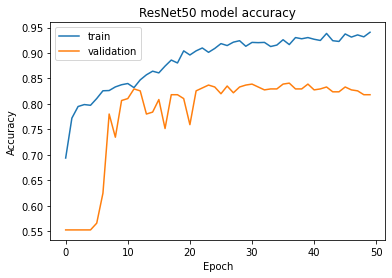

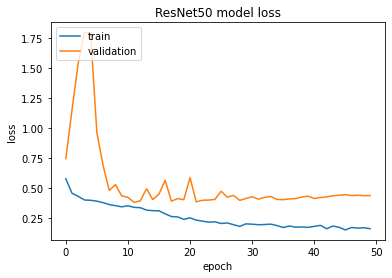

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ResNet50 model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ResNet50 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [ ]:
y_pred = model.predict(X_test)
print(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))*100)

21/21 [==============================] - 2s 97ms/step
84.3939393939394


In [ ]:
# save model
# serialize model to JSON
resnet50_json = model.to_json()

with open("resnet50.json", "w") as json_file:
    json_file.write(resnet50_json)
    
# serialize weights to HDF5
model.save_weights("resnet50.h5")
print("Saved model to disk")

Saved model to disk


Confusion matrix, without normalization
[[305  55]
 [ 48 252]]


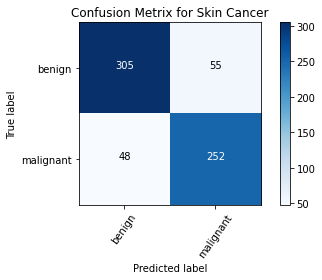

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report( np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.86      0.85      0.86       360
           1       0.82      0.84      0.83       300

    accuracy                           0.84       660
   macro avg       0.84      0.84      0.84       660
weighted avg       0.84      0.84      0.84       660



# ROC and AUC Curve

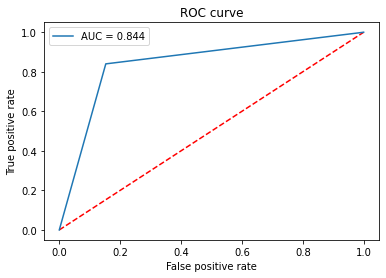

In [ ]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

In [ ]:
# set up plotting area
plt.figure(0).clf()

#fit logistic regression model and plot ROC curve
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Logistic Regression, AUC="+str(auc))

#fit gradient boosted model and plot ROC curve
model = GradientBoostingClassifier()
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Gradient Boosting, AUC="+str(auc))

#add legend
plt.legend()